## Automatic Speech Recognition (ASR)

### 0. Reference

[新手语音入门（四）： 传统语音识别技术简介 | 隐马尔可夫链 | 声学/语言模型 | WFST解码](https://bbs.huaweicloud.com/blogs/320751)    </br>
[新手语音入门（三）： 语音识别ASR算法初探 | 编码与解码 | 声学模型与语音模型 | 贝叶斯公式 | 音素](https://bbs.huaweicloud.com/blogs/320735) </br>
[语音识别(一):简介](https://zhuanlan.zhihu.com/p/501251939) </br>
[一文读懂NLP之隐马尔科夫模型（HMM）详解加python实现](https://blog.csdn.net/Elenstone/article/details/104902120)
[https://zhuanlan.zhihu.com/p/107481181](https://zhuanlan.zhihu.com/p/107481181)

### 1. Introduction of ASR

- **What is ASR** : 语音识别，通常称为自动语音识别`（AutomaticSpeechRecognition，ASR）`，主要是将人类语音中的词汇内容转换为计算机可读的输入，一般都是可以理解的文本内容，也有可能是二进制编码或者字符序列。但是，我们一般理解的语音识别其实都是狭义的语音转文字的过程，简称语音转文本识别`（Speech-To-Text,STT）`更合适，这样就能与语音合成`(Text-To-Speech,TTS)`对应起来。

#### 1.1 语音识别难点

ASR并不容易，因为有很多的可变性:

- **声学（acoustics）**:  speakers之间的可变性, 同一speakers的可变性, 噪声，房间里的混响，环境......

- **语音学（phonetics）**: 衔接（articulation）, 分词（将一些词分组，不发音）, 发音相似的词

- **语言学（linguistics）**: 词汇的大小, 词的变化

- **从机器学习的角度来看** ：非常高维的输出空间，以及一个复杂的序列对序列问题, 很少有注释的训练数据, 数据是有噪声的

#### 1.2 如何评价语音识别系统


通过比较每个output句子的 $\hat{W}$（output）和 $W_{\text{ref}}$（参考句子/label），计算出`词/音素（phone）错误率 (ER)`. 

- `ER` 使用列文斯坦距离测量法：将 $\hat{W}$ 转换成 $W_{\text{ref}}$ 所需的最小编辑数（插入/删除/替换）是多少？在一个有 $N$ 个实例的测试集上。

$$
ER = \frac{\sum_{j=1}^{N} (\text{Ins}_j + \text{Del}_j + \text{Sub}_j)}{\sum_{j=1}^{N} l_j}
$$

其中：  
- $\text{Ins}_j, \text{Del}_j, \text{Sub}_j$ 是第 $j$ 个 ASR 输出中的插入/删除/替换的数量。  
- $l_j$ 是第 $j$ 个参考中的单词/音素总数。


#### 1.3 Phonemes Instead of Words
- 在ASR中，你不会训练一个人工神经网络进行50,000个类的预测，每个类代表一个词。事实上，模型接受一个输入序列，并产生一个输出序列。而每个词都被表示为一个`音素（phoneme）`，是基于国际音标（IPA）的语言中的一组基本声音。英语中大约有48个音素。汉语大概有32个音素。

#### 1.4 Overview of ASR Architecture

ASR的过程如下图所示：

<figure>
<img src= "https://i-blog.csdnimg.cn/blog_migrate/f3c041cdcb837bfb38f2ff161da7e5f5.png" width=600/>
</figure>

- **编码过程**：语音识别的输入是声音，计算机无法直接处理，需要编码过程将其转变为数字信息，并提取其中的特征进行处理。编码时一般会将声音信号按照很短的时间间隔，切成小段，成为`帧 (frame)`。对于每一帧，可以通过某种规则（例如MFCC特征）提取信号中的特征，将其变成一个多维向量。向量中的每个维度都是这帧信号的一个特征。
<figure>
<img src= "https://bbs-img.huaweicloud.com/blogs/img/20211227/1640585589208039491.png" width=600/>
</figure>

<p>

- **解码过程**：解码过程则是将编码得到的向量变成文字的过程，需要经过两个模型的处理，一个模型是`声学模型`，一个模型是`语言模型`。
    - **声学模型**通过处理编码得到的向量，将相邻的帧组合起来变成`音素`，如中文拼音中的声母和韵母，再组合起来变成单个单词或汉字。
    - **语言模型**用来调整声学模型所得到的符合逻辑的字词，使识别结果变得通顺。

<p>

概率模型建模`ASR`过程: </br>


已知一段音频信号，处理成声学特征向量`Acoustic Feature Vector`后表示为，$ X=[x_{1},x_{2},x_{3},…] $, 其中 $x_{i}$ ​表示一帧特征向量；可能的文本序列表示为$W=[w_{1},w_{2},w_{3},…]$, 其中$w_{i}$​表示一个词，求 $ \hat{W} = \arg\max_W P(W \mid X) $，这便是语音识别的基本出发点。并且由贝叶斯公式可知：

$$
P(W \mid X) = \frac{P(X \mid W) P(W)}{P(X)} \propto P(X \mid W) P(W)
$$

其中，$P(X∣W)$称之为声学模型（Acoustic Model, AM）, $P(W)$称之为语言模型（Language Model, LM），由于$P(X)$一般是一个不变量，可以省去不算。

<p>

- 传统研究将语音识别问题看做声学模型与语音模型两部分，分别求取$P(X∣W)$ 和 $P(W)$。
- 后来，基于深度学习和大数据的端对端（End-to-End）方法发展起来，直接计算$P(W∣X)P(W∣X)$，把声学模型和语言模型融为了一体。

- 语音识别的问题可以看做是语音到文本的对应关系，语音识别问题大体可以归结为文本基本组成单位的选择上。单位不同，则建模力度也随之改变。

<figure>
<img src= "https://i-blog.csdnimg.cn/blog_migrate/417bff091acd31bb098c1cb2e42b7d7f.png" width=600/>
</figure>





### 2. Traditional ASR
#### 2.1 HMM

HMM 的解码过程，已知模型参数$ (A, B, \pi) $ ，给定观测序列$ \boldsymbol{x}$ （每帧的MFCC特征向量），求最有可能的状态序列$ \boldsymbol{s}$（states），即求 $p(\boldsymbol{s}|\boldsymbol{x})$的最大值。

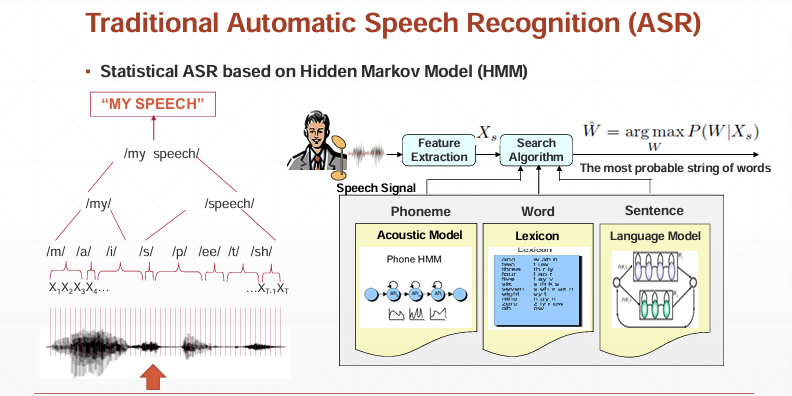


### 3. DNN-based ASR
#### 3.1 DNN-HMM, CLDNN-HMM
#### 3.2 TDNN, CTC
#### 3.3 Sequence-to-sequence, Listen and Spell, Enc-dec with attention
